# Solving combinatorial optimization problems with a quantum computer

### Authors:
- Ritajit Majumdar (IBM Quantum)
- Debasmita Bhoumik (IBM Quantum)

In this tutorial, you’ll learn how to use Qiskit to implement the Quantum Approximate Optimization Algorithm (QAOA) — a hybrid quantum-classical method — to solve the Maximum-Cut (Max-Cut) problem for a graph.

The Max-Cut problem is a tough one (it’s NP-hard!) with plenty of real-world applications, like clustering, network analysis, and statistical physics. The goal is pretty simple: divide the nodes of a graph into two groups so that the number of edges crossing between them is as large as possible. Using QAOA, you’ll see how quantum computing can help tackle problems like this in a really cool way by combining the power of both quantum and classical computation.

## Requirements
Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK v2.0 or later, with visualization support ( `pip install 'qiskit[visualization]' `)
- Qiskit Runtime 0.38 or later ( `pip install qiskit-ibm-runtime` )
- Qiskit Addon: Optimization modeling 0.1.0 or later (`pip install qiskit-addon-opt-mapper`)
- Rustworkx graph library ( `pip install rustworkx` )


## Example graph: A grid graph with 9 nodes placed on a 3x3 lattice

In [1]:
import rustworkx as rx
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

In [2]:
def generate_lattice_graph(rows, cols):
    """Generate a lattice graph with specified rows and columns using Rustworkx."""
    G = rx.PyGraph()
    node_indices = [
        G.add_node((row, col)) for row in range(rows) for col in range(cols)
    ]

    for row in range(rows):
        for col in range(cols):
            node = row * cols + col
            if col < cols - 1:  # Connect to the node to the right
                G.add_edge(node_indices[node], node_indices[node + 1], 1.0)
            if row < rows - 1:  # Connect to the node below
                G.add_edge(node_indices[node], node_indices[node + cols], 1.0)
    return G

def create_grid_layout(graph):
    """Create a grid layout for the Rustworkx graph."""
    layout = {}
    for node_index, (row, col) in enumerate(graph.nodes()):
        layout[node_index] = (col, -row)  # (x, y) positions
    return layout

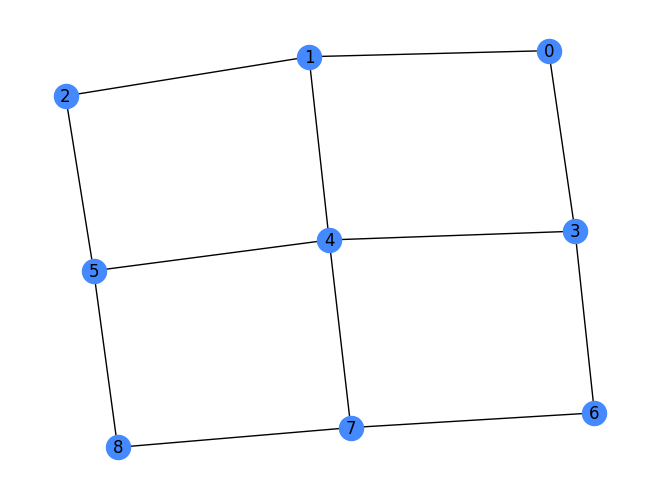

In [3]:
from rustworkx.visualization import mpl_draw

# Create a 3x3 lattice graph
rows, cols = 3, 3
rx_graph = generate_lattice_graph(rows, cols)

mpl_draw(rx_graph, with_labels=True, node_color='#4589ff')



### Reason for Choosing This Graph

1. **Verification Feasibility**: This graph is well-suited for verification purposes as it allows manual inspection of edge cuts, ensuring the results hold true even for larger graphs. For simulation, a 3x3 graph has been chosen to maintain simplicity.

2. **Mapping Visualization**: The chosen graph helps in visualizing potential mapping challenges, such as the introduction of SWAP gates when mapping onto hardware. These issues will be discussed in detail later.

## Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum circuits and operators. As discussed, we shall assume that each node in the graph has an associated qubit.

- First we shall convert the input graph into a Hamiltonian
- Next we shall construct the QAOA circuit for the graph

#### Convert graph to Hamiltonian

The input graph needs to be converted into the Hamiltonian. For this, we shall use `Qiskit Addon: Optimization modeling`. The steps here are

- convert the graph into an optimization problem
- convert the optimization problem into QUBO (note that for this case, the optimization problem is in QUBO itself)
- convert the QUBO into its Ising form, which will be the Hamiltonian

Qiskit Addon: Optimization modeling contains some well defined problems such as MaxCut, Independent Set etc. as applications. However, any other optimization problem, which is not a part of the set of applications included in Qiskit Addon: Optimization modeling can also be converted into the Hamiltonian by the above steps. In that case the problem needs to be provided explicitly as an optimization problem instead of a graph.

In [4]:
from qiskit_addon_opt_mapper.applications import Maxcut
from qiskit_addon_opt_mapper.converters import OptimizationProblemToQubo

In [5]:
# convert the graph into a MaxCut optimization problem
max_cut_problem = Maxcut(graph=rx_graph).to_optimization_problem()

# convert the optimization problem into QUBO
qubo_converter = OptimizationProblemToQubo()
max_cut_qubo = qubo_converter.convert(max_cut_problem)

In [6]:
print(max_cut_qubo.prettyprint())

Problem name: 

Minimize
  2*x_0*x_1 + 2*x_0*x_3 + 2*x_1*x_2 + 2*x_1*x_4 + 2*x_2*x_5 + 2*x_3*x_4
  + 2*x_3*x_6 + 2*x_4*x_5 + 2*x_4*x_7 + 2*x_5*x_8 + 2*x_6*x_7 + 2*x_7*x_8
  - 2*x_0 - 3*x_1 - 2*x_2 - 3*x_3 - 4*x_4 - 3*x_5 - 2*x_6 - 3*x_7 - 2*x_8

Subject to
  No constraints

  Binary variables (9)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8



In [7]:
max_cut_hamiltonian = max_cut_qubo.to_ising()[0]
max_cut_hamiltonian

SparsePauliOp(['IIIIIIIZZ', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIZIIZI', 'IIIZIIZII', 'IIIIZZIII', 'IIZIIZIII', 'IIIZZIIII', 'IZIIZIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZZIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

#### Construct the QAOA circuit

In [9]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from typing import Optional

def construct_qaoa_circuit(hamiltonian: SparsePauliOp, p: int=1, 
                           barrier: Optional[bool]=False, measure: Optional[bool]=False) -> QuantumCircuit:
    """Construct a QAOA circuit for the given Hamiltonian and depth p."""
    num_qubits = hamiltonian.num_qubits
    qc = QuantumCircuit(num_qubits)

    # Initialize in uniform superposition
    qc.h(range(num_qubits))

    # Define parameters
    gamma = ParameterVector('γ', p)
    beta = ParameterVector('β', p)

    # Apply p layers of QAOA
    for layer in range(p):
        # Problem unitary
        for term in hamiltonian.to_list():
            pauli_string, _ = term[0], term[1]
            qubits = [index for index, pauli in enumerate(pauli_string[::-1]) if pauli != 'I']
            if qubits:
                qc.rzz(gamma[layer], qubits[0], qubits[1])  # Assuming 2-qubit terms

        # Mixer unitary
        qc.rx(2 * beta[layer], range(num_qubits))
        if barrier and layer != p - 1:
            qc.barrier()
    
    if measure:
        qc.measure_all()

    return qc


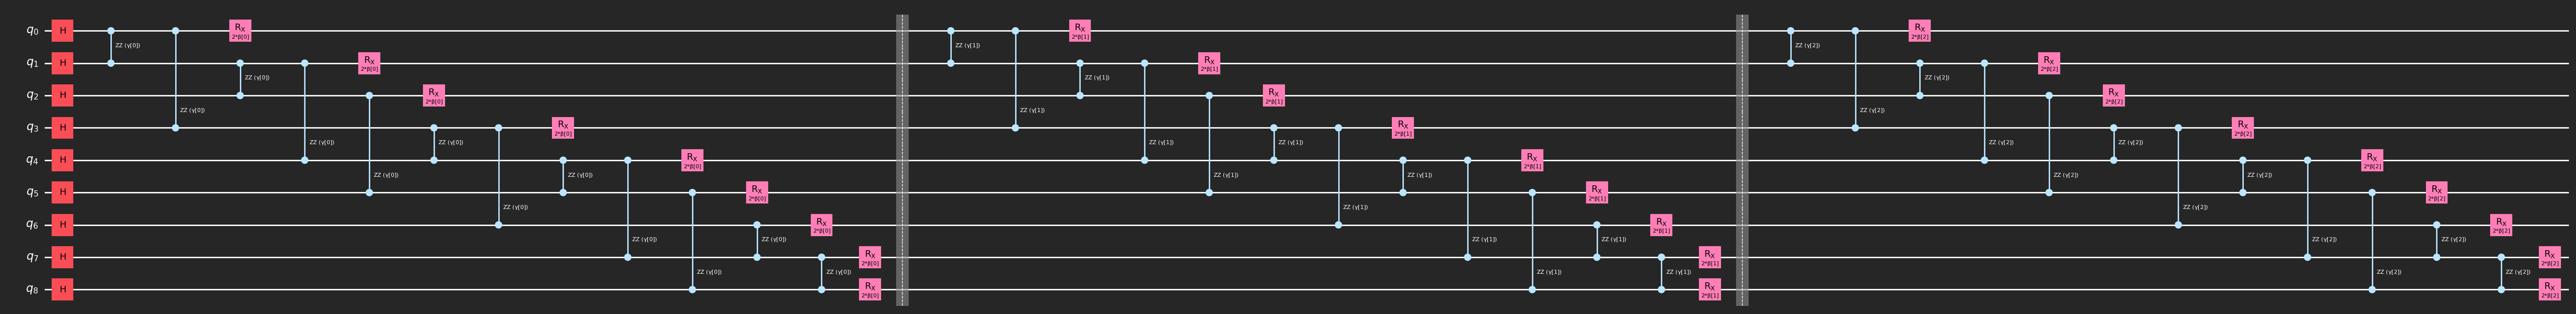

In [11]:
p = 3
qaoa_circuit = construct_qaoa_circuit(max_cut_hamiltonian, p=p, barrier=True)
qaoa_circuit.draw('mpl', fold=-1, style='iqp-dark')

In [12]:
print(f'Depth of the QAOA circuit is {qaoa_circuit.depth()}')


Depth of the QAOA circuit is 28


#### But hey, we can actually reduce the circuit depth. 

Let us consider edge coloring where disjoint edges can have same colors. In other words, edge with same colors imply two-qubit operations on disjoint qubit pairs, and hence can be performed parallely. Note that the graph in consideration is 4-colorable due to its maximum degree of 4. Even if the size of the graph increases, it remains 4-colorable.

In [13]:
# Perform edge coloring using Rustworkx
edge_coloring = rx.graph_bipartite_edge_color(rx_graph)
edge_colors = [edge_coloring[i] for i in range(len(rx_graph.edges()))]

print("Edge Coloring:")
for edge_idx, color in edge_coloring.items():
    endpoints = rx_graph.get_edge_endpoints_by_index(edge_idx)
    print(f"Edge {endpoints} has color {color}")

Edge Coloring:
Edge (0, 1) has color 3
Edge (0, 3) has color 2
Edge (1, 2) has color 2
Edge (1, 4) has color 1
Edge (2, 5) has color 3
Edge (3, 4) has color 3
Edge (3, 6) has color 0
Edge (4, 5) has color 0
Edge (4, 7) has color 2
Edge (5, 8) has color 2
Edge (6, 7) has color 3
Edge (7, 8) has color 1


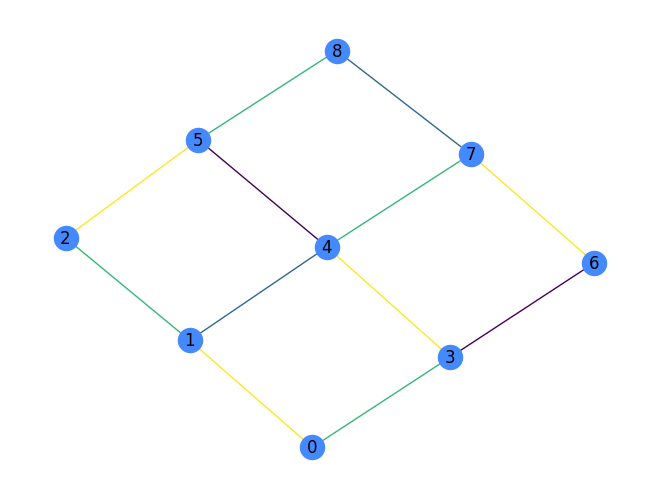

In [14]:
mpl_draw(rx_graph, with_labels=True, node_color='#4589ff', edge_color=edge_colors)

#### Constructing lower depth QAOA circuit using edge coloring

Now, we use the information of edge coloring to group the two qubit operations. This will reduce the depth of the QAOA circuit.

In [17]:
def construct_qaoa_circuit_with_coloring(hamiltonian: SparsePauliOp, edge_coloring: dict, p: int=1, 
                                        barrier: Optional[bool]=False, measure: Optional[bool]=False) -> QuantumCircuit:
    """Construct a QAOA circuit for the given Hamiltonian and depth p using edge coloring."""
    num_qubits = hamiltonian.num_qubits
    qc = QuantumCircuit(num_qubits)

    # Initialize in uniform superposition
    qc.h(range(num_qubits))

    # Define parameters
    gamma = ParameterVector('γ', p)
    beta = ParameterVector('β', p)

    # Apply p layers of QAOA
    for layer in range(p):
        # Problem unitary grouped by edge colors
        max_color = max(edge_coloring.values())
        for color in range(max_color + 1):
            for edge_idx, edge_color in edge_coloring.items():
                if edge_color == color:
                    term = hamiltonian.to_list()[edge_idx]
                    pauli_string, _ = term[0], term[1]
                    qubits = [index for index, pauli in enumerate(pauli_string[::-1]) if pauli != 'I']
                    if qubits:
                        qc.rzz(gamma[layer], qubits[0], qubits[1])  # Assuming 2-qubit terms
        if barrier:
            qc.barrier()

        # Mixer unitary
        qc.rx(2 * beta[layer], range(num_qubits))
        if barrier and layer != p - 1:
            qc.barrier()
    
    if measure:
        qc.measure_all()

    return qc

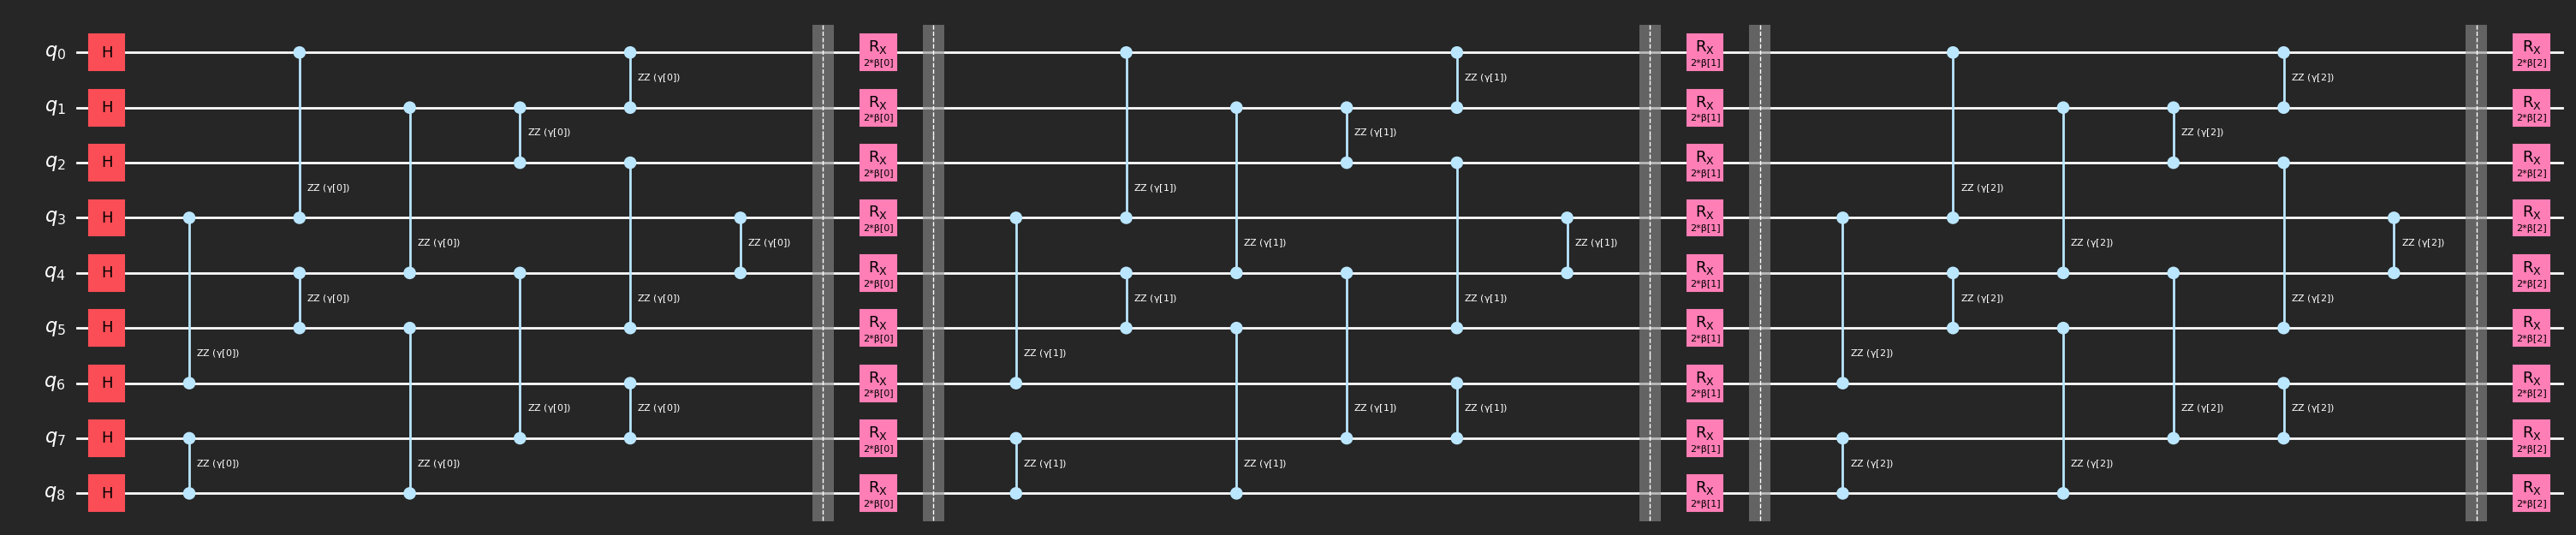

In [18]:
qaoa_circuit_edge_colored = construct_qaoa_circuit_with_coloring(max_cut_hamiltonian, edge_coloring, p=p, barrier=True)
qaoa_circuit_edge_colored.draw('mpl', fold=-1, style='iqp-dark')

In [19]:
print(f'Depth of the QAOA circuit with edge coloring is {qaoa_circuit_edge_colored.depth()}')

Depth of the QAOA circuit with edge coloring is 16


## Step 2. Optimize circuits for quantum hardware execution


To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the transpilation or circuit optimization step. The Qiskit library offers a series of transpilation passes that cater to a wide range of circuit transformations. You need to make sure that your circuit is optimized for your purpose.

Transpilation may involves several steps, such as:

1. Initial mapping of the qubits in the circuit (such as decision variables) to physical qubits on the device.

2. Unrolling of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.

3. Routing of any qubits in the circuit that interact to physical qubits that are adjacent with one another.

In [20]:
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
backend = FakeKolkataV2()

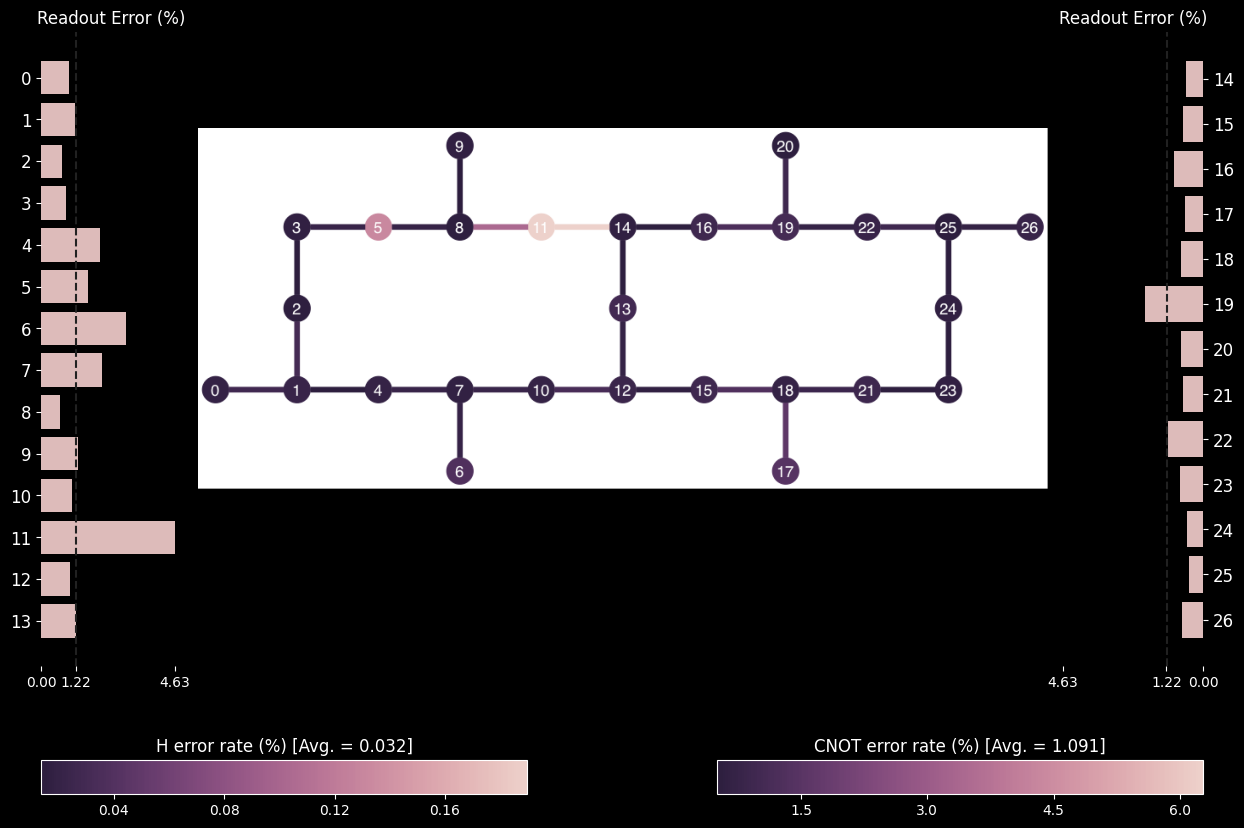

In [21]:
from qiskit.visualization import plot_error_map
from qiskit.visualization import plot_coupling_map

plot_error_map(backend, show_title=False)

In [22]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

#### Transpilation with SWAP gate (for understanding)

In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm_swap = generate_preset_pass_manager(optimization_level=3, 
                                       coupling_map=backend.configuration().coupling_map,
                                       basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset', 'swap']
                                      )

### Key Observations

- The original graph has a degree of 4, whereas the coupling map lacks degree 4 connectivity. As a result, SWAP operations become mandatory. However, it is crucial to minimize the number of SWAPs, a task handled by the transpiler.

- **Need for Basis Gates**: Basis gates are essential because it is impractical to physically implement infinite unitary gates. This concept is analogous to NAND and NOR gates in digital logic, which can be used to design any other gate.

- **Optimization Level**: We select optimization level 3, as it is the maximum available optimization level.

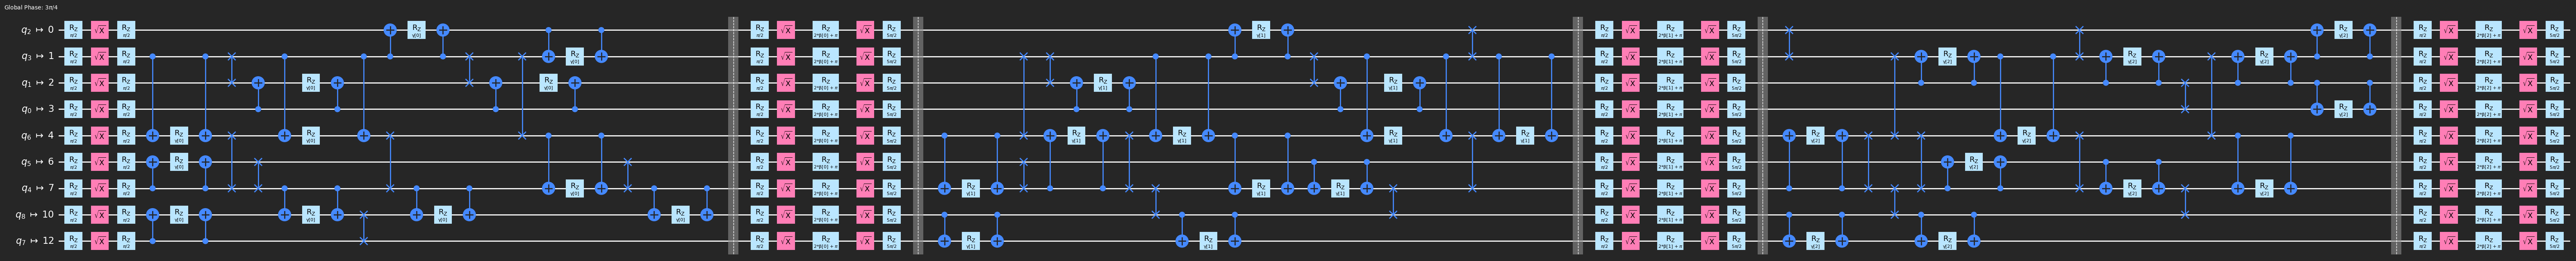

In [24]:
swap_circuit = pm_swap.run(qaoa_circuit_edge_colored)
swap_circuit.draw('mpl', idle_wires=False, style='iqp-dark', fold=-1)

#### Transpilation on (fake) backend

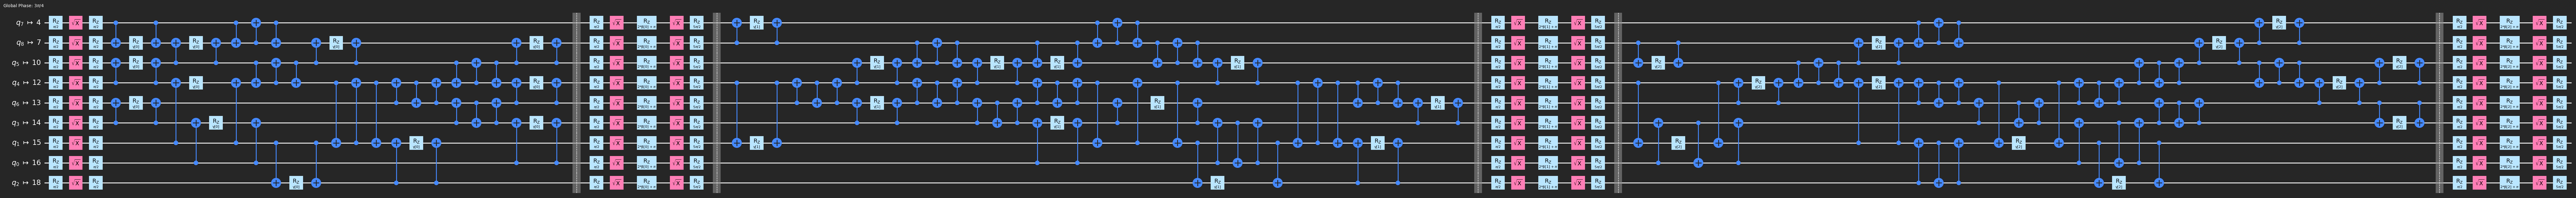

In [25]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

isa_circuit = pm.run(qaoa_circuit_edge_colored)
isa_circuit.draw('mpl', idle_wires=False, style='iqp-dark', fold=-1)

#### Apply the layout to the Hamiltonian

In [26]:
isa_hamiltonian = max_cut_hamiltonian.apply_layout(isa_circuit.layout)
isa_hamiltonian

SparsePauliOp(['IIIIIIIIIIIIZZIIIIIIIIIIIII', 'IIIIIIIIIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIZZIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIZIIIIIIIIII', 'IIIIIIIIZIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIZIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIZIIIIIII', 'IIIIIIIIZIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIZIIII', 'IIIIIIIIZIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIZIIII', 'IIIIIIIIIIZIIIIIIIIIIIZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

## Step 3. Execute using Qiskit primitives

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal β and γ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters
2. Instantiate a new Session containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.

In [27]:
init_params = [0]*(2*p)
init_params

[0, 0, 0, 0, 0, 0]

### Define backend and execution primitive

Next we use the Qiskit Runtime primitives for execution. There are two primitives
- Sampler: used to obtain the probability distribution after execution
- Estimator: used to obtain the expectation value of some observable

For the Max-Cut problem, we want to minimize the expectation value of $\langle H_P \rangle$.

In [28]:
def cost_func_estimator(params, isa_circuit, isa_hamiltonian, estimator):
    
    pub = (isa_circuit, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    
    return cost

#### Ideal simulation

First we shall run the circuit on a noiseless ideal simulator. Note that to execute on an ideal simulator, it is not necessary to transpile the circuit as we have done here. But transpilation is necessary when we want to go for noisy simulation, or real hardware execution.

In [55]:
from qiskit_ibm_runtime import EstimatorV2
from qiskit_aer import AerSimulator

simulator = AerSimulator()
ideal_estimator = EstimatorV2(mode=simulator)

In [56]:
from scipy.optimize import minimize

ideal_result = minimize(
                cost_func_estimator,
                init_params,
                args=(isa_circuit.copy(), isa_hamiltonian, ideal_estimator),
                method="COBYLA",
            )

In [57]:
ideal_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.896240234375
       x: [ 2.167e-01  8.141e-01  1.338e+00  7.379e-01 -3.453e-01
            7.752e-01]
    nfev: 63
   maxcv: 0.0

## Step 4: Post process and return result in classical format

We have performed the minimization. Now, we need to

- extract the optimal parameters
- run the circuit with the optimal parameters and store the obtained bitstring
- obtain the most likely bitstring, and visualize the cut 

In [58]:
optimal_params = ideal_result.x
optimal_params

array([ 0.21670532,  0.81406232,  1.33779164,  0.73790884, -0.3453337 ,
        0.77522273])

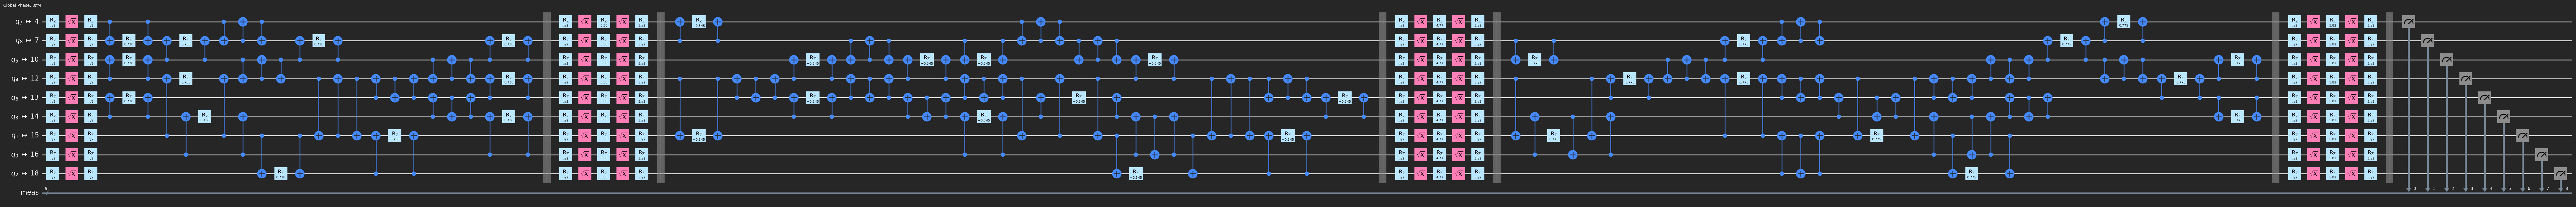

In [59]:
optimal_circuit = isa_circuit.assign_parameters(optimal_params)
optimal_circuit.measure_active()
optimal_circuit.draw('mpl', idle_wires=False, style='iqp-dark', fold=-1)

In [60]:
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(mode=simulator)

pub = (optimal_circuit, )
job = sampler.run([pub])
result = job.result()[0]
counts = result.data.meas.get_counts()


In [61]:
counts

{'011010110': 182,
 '011001100': 16,
 '100010110': 25,
 '100110011': 23,
 '110110110': 3,
 '011101100': 7,
 '100101001': 210,
 '110100010': 6,
 '100011110': 1,
 '001010111': 11,
 '010101010': 6,
 '001101001': 8,
 '101010011': 3,
 '001011001': 3,
 '001001001': 5,
 '001010001': 2,
 '010010110': 10,
 '011101001': 16,
 '110101010': 21,
 '011001110': 11,
 '001010101': 20,
 '110101000': 5,
 '100010101': 3,
 '100110010': 4,
 '001010110': 13,
 '100110001': 13,
 '100111001': 10,
 '101010101': 6,
 '100000101': 1,
 '100011001': 8,
 '101101001': 10,
 '010101110': 6,
 '101010110': 11,
 '100101011': 9,
 '000010011': 1,
 '011011100': 16,
 '101011001': 5,
 '101100001': 1,
 '100110101': 1,
 '101010111': 5,
 '011000110': 13,
 '100010111': 8,
 '011101101': 1,
 '011010100': 5,
 '011011001': 8,
 '010101001': 9,
 '011101110': 7,
 '010111100': 1,
 '011011010': 1,
 '011101000': 5,
 '110100110': 7,
 '010101000': 6,
 '010100110': 19,
 '100101010': 12,
 '000100010': 2,
 '010000110': 2,
 '100100110': 8,
 '0110011

In [62]:
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

{'100101001': 210,
 '011010110': 182,
 '100010110': 25,
 '100110011': 23,
 '110101010': 21,
 '001010101': 20,
 '010100110': 19,
 '011001100': 16,
 '011101001': 16,
 '011011100': 16,
 '001010110': 13,
 '100110001': 13,
 '011000110': 13,
 '110101001': 13,
 '100101010': 12,
 '011010101': 12,
 '001010111': 11,
 '011001110': 11,
 '101010110': 11,
 '010010110': 10,
 '100111001': 10,
 '101101001': 10,
 '100101011': 9,
 '010101001': 9,
 '100100011': 9,
 '001101001': 8,
 '100011001': 8,
 '100010111': 8,
 '011011001': 8,
 '100100110': 8,
 '001011101': 8,
 '011011101': 8,
 '011101100': 7,
 '011101110': 7,
 '110100110': 7,
 '011100110': 7,
 '110100010': 6,
 '010101010': 6,
 '101010101': 6,
 '010101110': 6,
 '010101000': 6,
 '010110110': 6,
 '110010110': 6,
 '001001001': 5,
 '110101000': 5,
 '101011001': 5,
 '101010111': 5,
 '011010100': 5,
 '011101000': 5,
 '011001101': 5,
 '101001001': 5,
 '100110010': 4,
 '011101010': 4,
 '011001001': 4,
 '100110110': 4,
 '011001000': 4,
 '100010011': 4,
 '00100

In [63]:
most_likely_bitstring = list(sorted_counts.keys())[0][::-1]
most_likely_bitstring


'100101001'

In [64]:
def visualize_solution(graph, solution_bitstring: str):
    """Visualize the MIS solution on the graph."""
    pos = rx.spring_layout(graph, seed=42)
    node_colors = ['#8a3ffc' if solution_bitstring[i] == '1' else '#3ddbd9'
                   for i in range(len(solution_bitstring))]

    plt.figure(figsize=(8, 6))
    mpl_draw(graph, pos, node_color=node_colors, with_labels=True,
            node_size=500, font_size=16, font_weight='bold')
    plt.title("Max Cut Solution")
    plt.show()

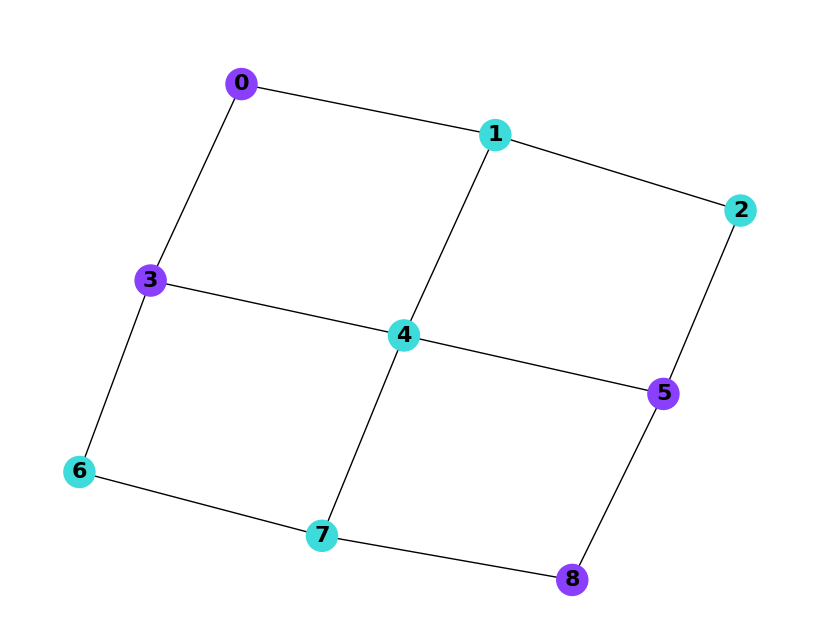

In [65]:
visualize_solution(rx_graph, most_likely_bitstring)

##### Let us visualize the second best bitstring

In [66]:
second_most_likely_bitstring = list(sorted_counts.keys())[1][::-1]
second_most_likely_bitstring

'011010110'

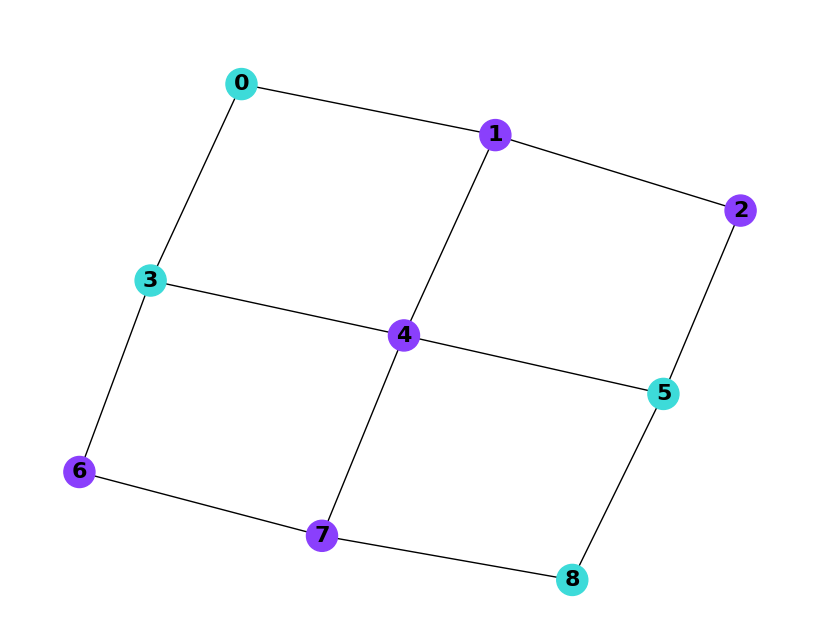

In [67]:
visualize_solution(rx_graph, second_most_likely_bitstring)

### Don't forget about noise!

We did an ideal (noiseless) simulation. But noise in an unavoidable part of the current quantum devices. We can get an estimate of how noise will affect our algorithm by going a noisy simulation. Note that noisy simulation is only possible for small scale ($O(10-15)$ qubits) circuit. For larger circuits, you have to go directly to the hardware.

We already have our transpiled circuit. All we need to do in this step is to replace the simulator with the FakeBackend.

In [69]:
noisy_estimator = EstimatorV2(mode=backend)

In [70]:
noisy_result = minimize(
                cost_func_estimator,
                init_params,
                args=(isa_circuit.copy(), isa_hamiltonian, ideal_estimator),
                method="COBYLA",
            )

In [71]:
noisy_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.714599609375
       x: [ 9.216e-02  8.599e-01  1.183e+00  6.232e-01 -1.276e-01
            8.414e-01]
    nfev: 73
   maxcv: 0.0

We already notice that the value of the function `fun` is somewhat higher in the noisy simulation than in ideal simulation. This implies that the obtained cost function is worse.

In [72]:
optimal_noisy_params = noisy_result.x
optimal_noisy_params

array([ 0.09215572,  0.85985849,  1.18285265,  0.6231947 , -0.1276256 ,
        0.84143527])

In [73]:
optimal_noisy_circuit = isa_circuit.assign_parameters(optimal_noisy_params)
optimal_noisy_circuit.measure_active()

In [74]:
noisy_sampler = SamplerV2(mode=backend)

noisy_pub = (optimal_noisy_circuit, )
noisy_job = noisy_sampler.run([noisy_pub])
noisy_result = noisy_job.result()[0]
noisy_counts = noisy_result.data.meas.get_counts()

In [75]:
sorted_noisy_counts = {k: v for k, v in sorted(noisy_counts.items(), key=lambda item: item[1], reverse=True)}

In [76]:
most_likely_noisy_bitstring = list(sorted_noisy_counts.keys())[0][::-1]
second_most_likely_noisy_bitstring = list(sorted_noisy_counts.keys())[1][::-1]

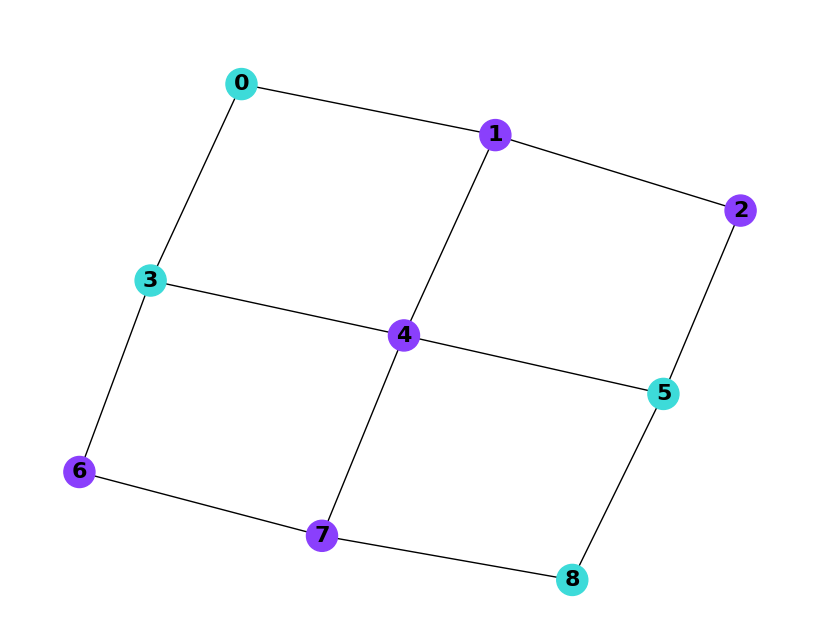

In [77]:
visualize_solution(rx_graph, most_likely_noisy_bitstring)

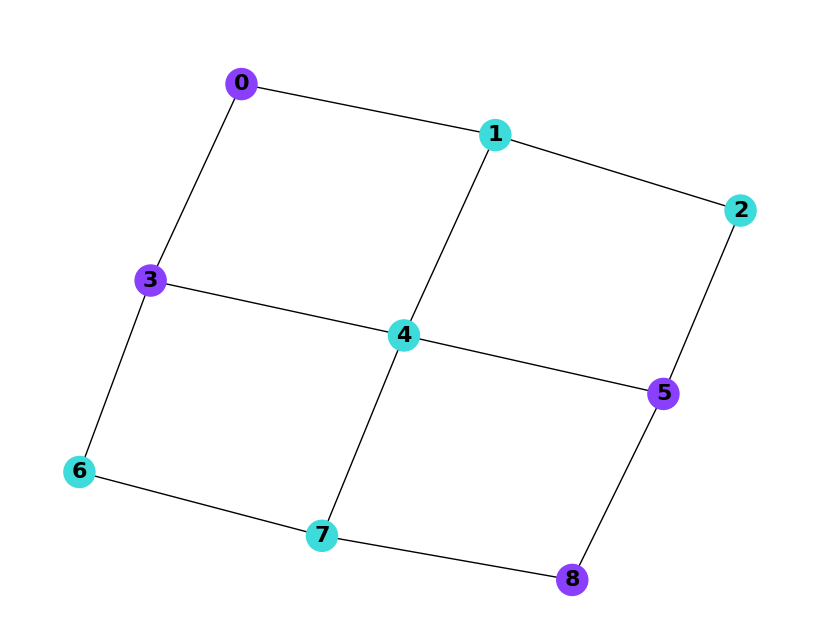

In [78]:
visualize_solution(rx_graph, second_most_likely_noisy_bitstring)

### Execution on real hardware

In order to execute on real hardware

```
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_cloud', token=<YOUR_API_TOKEN>, instance=<YOUR_FAVOURITE_INSTANCE>)
backend = service.backend(<YOUR_FAVOURITE_BACKEND>)

estimator = EstimatorV2(mode=backend)
sampler = SamplerV2(mode=backend)
```

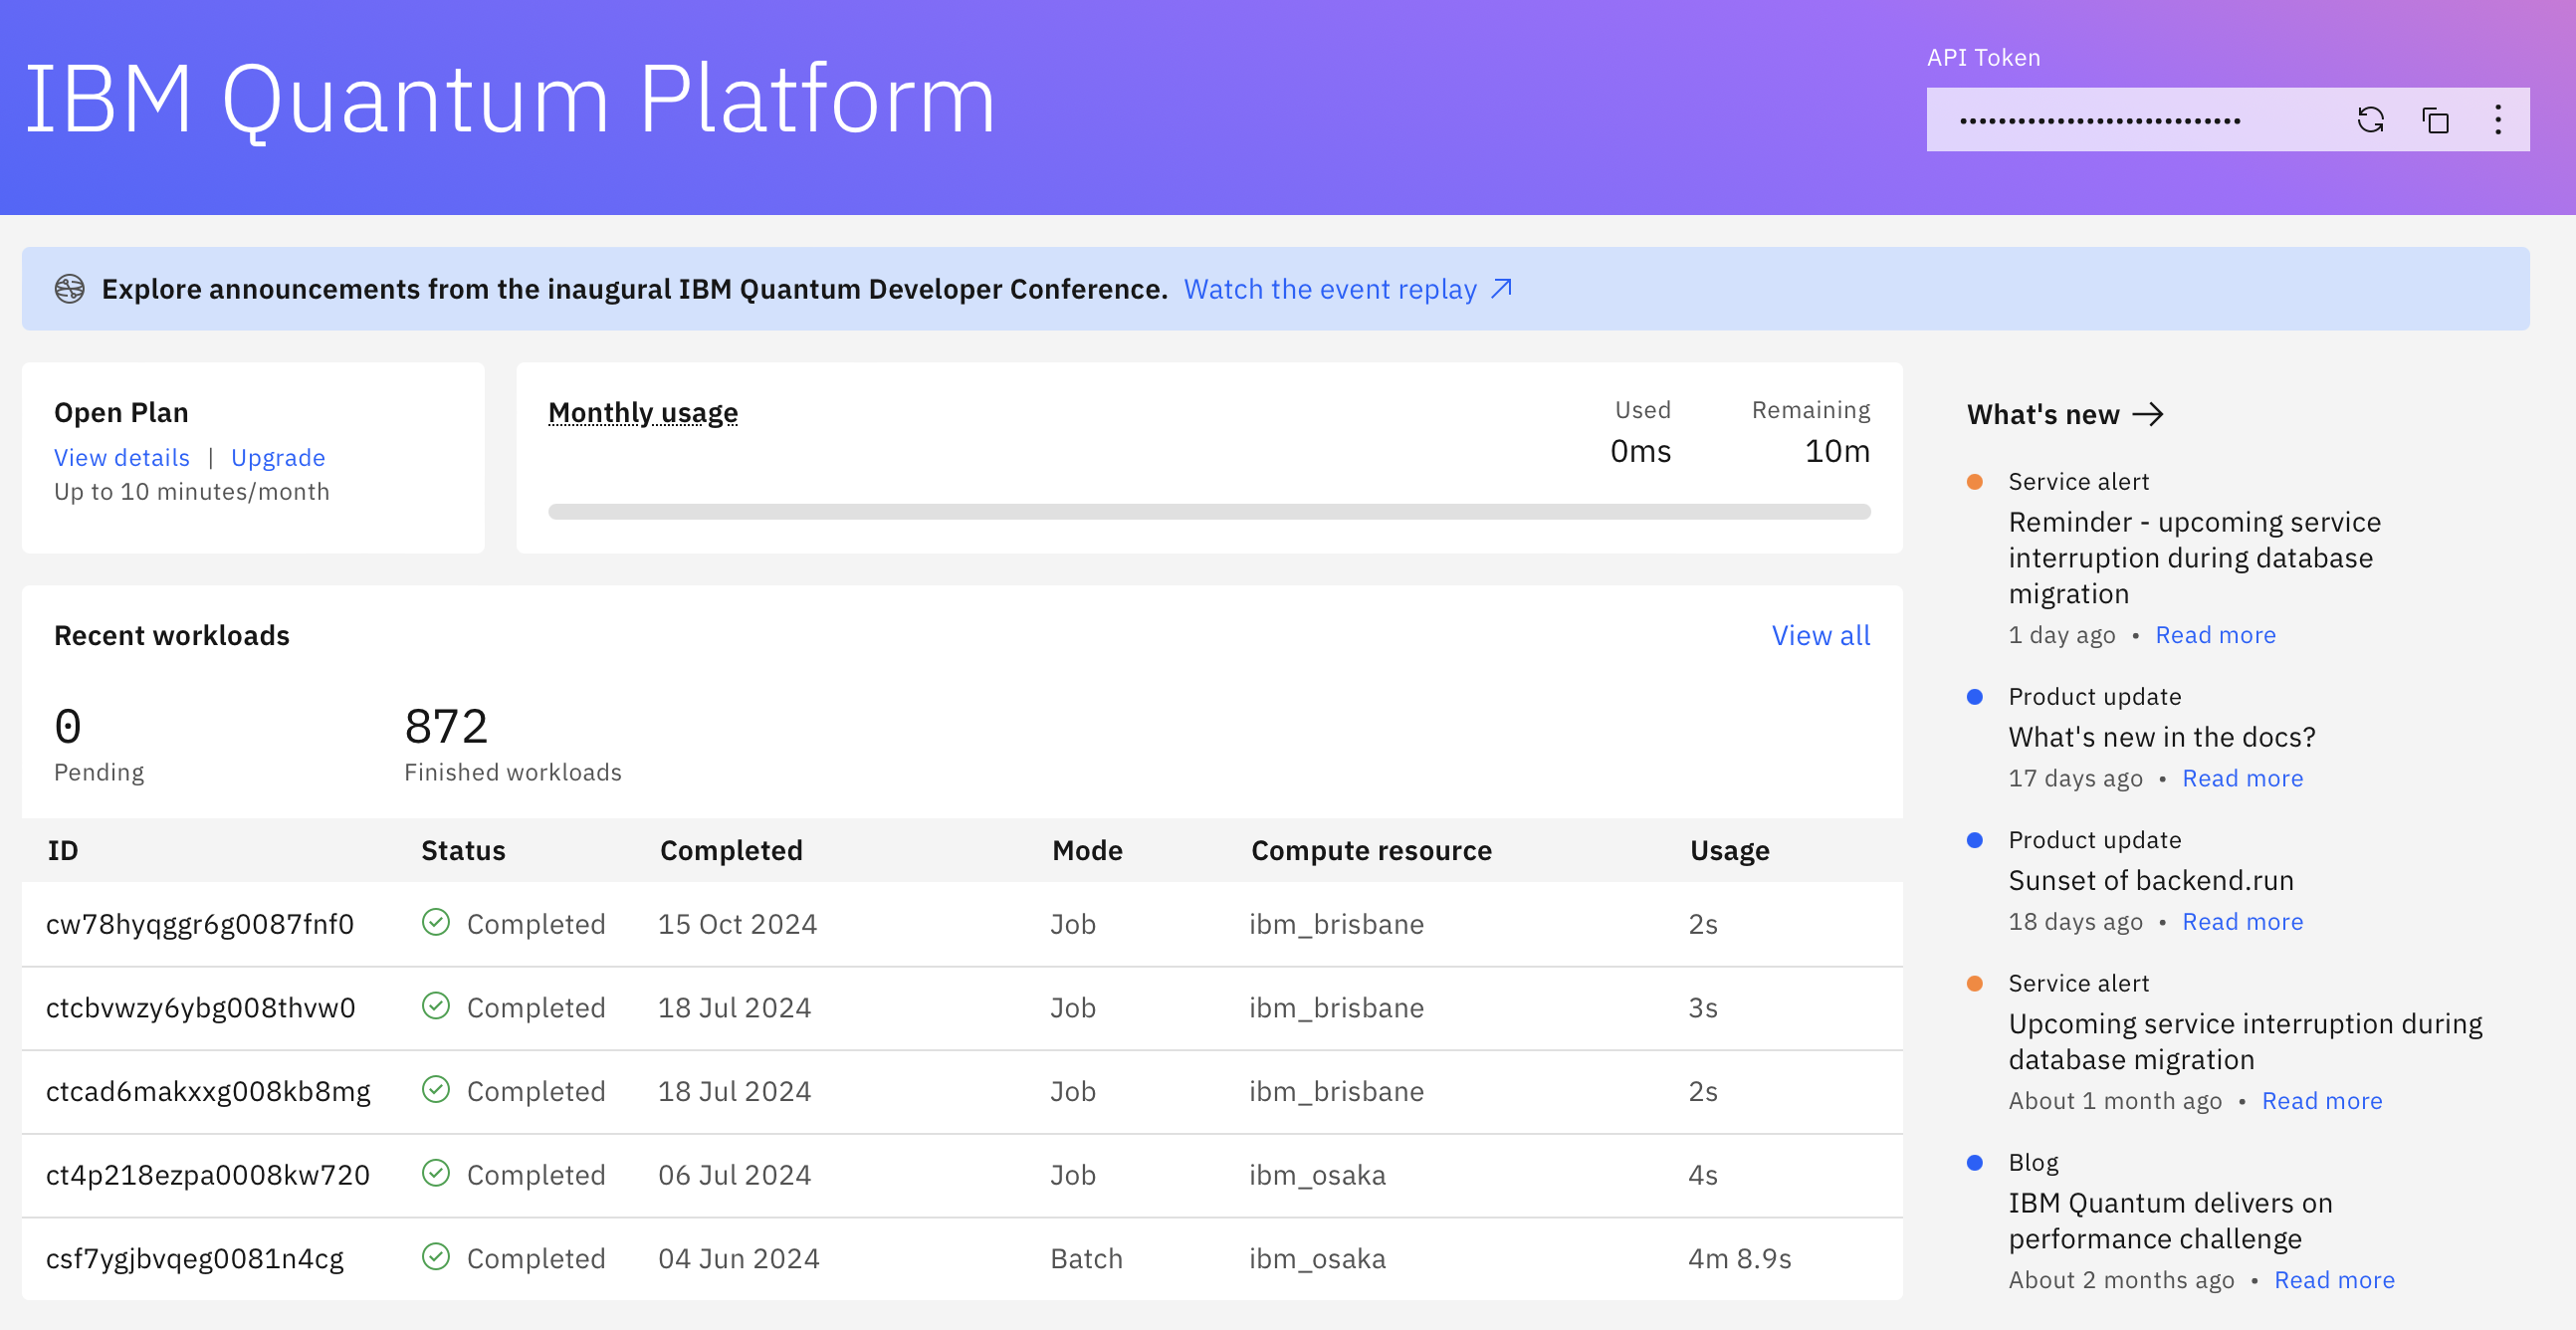